# Data collection and description (milestone 2)

The goal of this part is to collect, enrich, transform and analyze data for our project.

Most of the data collection code is implemented in Python files, the description is mostly in this notebook.

In [1]:
import ada
from ada import data
from ada.progressbar import ProgressBar
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import numpy as np
from datetime import datetime
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Data collection

The outline of our process can be described by the following steps:
1. Load the raw datasets to get a rough estimate of its content
2. Get a matching between movie titles and book titles (in our case, we scrap Wikipedia)
3. Filter the metadata and reviews to keep only the ones for which we have a matching
4. Merge the metadata and reviews on the `asin` number of the product
5. Apply the matching between movies and books to our data to assign a franchise_id to each product

## Global data description

From [the Amazon dataset][dataset], we used the deduplicated per-category files to download the subset of data relevant to our project.
Here are the files we use:

- `reviews_Books.json.gz`
- `meta_Books.json.gz`
- `reviews_Movies_and_TV.json.gz`
- `meta_Movies_and_TV.json.gz`

We decided not to use the reviews for Amazon Instant videos because a large majority of products are not related to a title, we have noticed that we could use the Amazon Product API but we think we have enough data with the 2 firsts categories.

We constructed our code so that we can handle both plain and compressed json files (`.json` and `.json.gz`), so that we can avoid extracting json files if memory is limited. 

We worked on our PC as the size of the data is small (about 8gb for compressed files and 25gb for plain files)

[dataset]: http://jmcauley.ucsd.edu/data/amazon/

### Books reviews

- Number of lines:
  ```bash
  $ wc -l reviews_Books.json
  22507155 reviews_Books.json
  ```

This matches the number on the website.

In [2]:
pd.DataFrame.from_dict(data.read_data("reviews_Books", 5))

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0000000116,"[5, 5]",4.0,Interesting Grisham tale of a lawyer that take...,"04 27, 2002",AH2L9G3DQHHAJ,chris,Show me the money!,1019865600
1,0000000116,"[0, 0]",1.0,The thumbnail is a shirt. The product shown i...,"03 24, 2014",A2IIIDRK3PRRZY,Helene,Listing is all screwed up,1395619200
2,0000000868,"[10, 10]",4.0,I'll be honest. I work for a large online reta...,"09 11, 2002",A1TADCM7YWPQ8M,Joel@AWS,Not a Bad Translation,1031702400
3,0000013714,"[0, 0]",4.0,It had all the songs I wanted but I had ordere...,"10 31, 2013",AWGH7V0BDOJKB,Barbara Marshall,Not the large print,1383177600
4,0000013714,"[0, 0]",5.0,"We have many of the old, old issue. But the nu...","07 27, 2013",A3UTQPQPM4TQO0,betty burnett,I was disappointed that you would only allow m...,1374883200


Basic description of features : 
- reviewerID: ID of the product, will be used to match metadata
- asin: ID of the reviewer
- reviewerName: name of the reviewer
- helpful:  helpfulness rating of the review, represented as a tuple `[helpful_votes, total_votes]`. For example `[5, 5]` in the first rows means that 5/5 people found this comment helpful.
- reviewText: Content of the review
- overall: rating of the product
- summary: summary of the review
- unixReviewTime: Time of the review as a UNIX timestamp (seconds since the UNIX epoch)
- reviewTime: time of the review in " month day,year" format


Given the size of the data, we'll use a custom function to get a rough estimate of the data without having to load it completely in memory.

In [3]:
# WARNING: Long operation (about 15-30 minutes)
ada.collect.print_reviews_description(ada.collect.describe_reviews(data.read_data("reviews_Books", 22507155)))


    Number of unique reviewers: 8026324 (35.66121084606206%), 9.659449560656222 reviews per user
    Number of unique products: 2330066 (10.352556775834174%), 2.8041672626223413 reviews per product
    Rated comments (helpfulness): 12034001 (53.46744624098426%)
    Non rated comments (helpfulness): 10473154 (46.53255375901574%)
    Average comment helpfulness: 0.7288443590389628
    Mean overall score: 4.29575892643917
    Time of oldest review: 1996-05-20 02:00:00 (832550400)
    Time of newest review: 2014-07-23 02:00:00 (1406073600)
    


Results : 

> ```
> Number of unique reviewers: 8026324 (35.66121084606206%), 9.659449560656222 reviews per user
> Number of unique products: 2330066 (10.352556775834174%), 2.8041672626223413 reviews per product
> Rated comments (helpfulness): 12034001 (53.46744624098426%)
> Non rated comments (helpfulness): 10473154 (46.53255375901574%)
> Average comment helpfulness: 0.7288443590389628
> Time of oldest review: 1996-05-20 02:00:00 (832550400)
> Time of newest review: 2014-07-23 02:00:00 (1406073600)
> ```

We can already notice a high mean for overall reviews

### Books metadata

* Number of lines:
  ```bash
  wc -l meta_Books.json
  2370585 meta_Books.json
  ```

In [4]:
pd.DataFrame.from_dict(data.read_data("meta_Books", 6))

,asin,categories,description,imUrl,price,related,salesRank,title
0,0001048791,[[Books]],NaN,http://ecx.images-amazon.com/images/I/51MKP0T4...,NaN,NaN,{'Books': 6334800},"The Crucible: Performed by Stuart Pankin, Jero..."
1,0001048775,[[Books]],William Shakespeare is widely regarded as the ...,http://ecx.images-amazon.com/images/I/5166EBHD...,NaN,NaN,{'Books': 13243226},Measure for Measure: Complete &amp; Unabridged
2,0001048236,[[Books]],"&#34;One thing is certain, Sherlockians, put a...",http://ecx.images-amazon.com/images/I/51DH145C...,9.26,"{'also_viewed': ['1442300191', '9626349786', '...",{'Books': 8973864},The Sherlock Holmes Audio Collection
3,0000401048,[[Books]],NaN,http://ecx.images-amazon.com/images/I/41bchvIf...,NaN,{'also_viewed': ['068240103X']},{'Books': 6448843},The rogue of publishers' row;: Confessions of ...
4,0001019880,[[Books]],NaN,http://ecx.images-amazon.com/images/I/61LcHUdv...,5.39,"{'also_viewed': ['B003HMB5FC', '0834004593'], ...",{'Books': 9589258},Classic Soul Winner's New Testament Bible
5,0001048813,[[Books]],NaN,http://ecx.images-amazon.com/images/I/41k5u0lr...,NaN,NaN,NaN,Archer Christmas 4 Tape Pack


Basic description of features : 
* asin : ID of the product
* salesRank : sales rank information
* imUrl : url of the product image
* categories : list of categories the product belongs to
* title : name of the product
* price : price in US dollars
* description : product description
* related : related products, for example product that was also bought
* brand : brand name


This time the file is small enough to load it in memory with pandas but due to the format of the input it's faster to make a custom read.

For example we can not use the `unique` function to list categories as they are in a list format which are unhashable

In [5]:
sales_category = 'Books'
ada.collect.print_meta_description(ada.collect.describe_meta(data.read_data("meta_Books", 2370585), sales_category))


    Number of products: 2370585
    Number of unique categories: 3935
    Number of products with price: 1679410 (70.84369469983147%)
    Mean price: 17.62630714920411
    Number of products with sales rank: 1891017 (79.77005675814198%)
    Mean sales rank: 2837317.7674769713
    Min sales rank: 1
    Max sales rank: 14690268
    Number of products with a title: 1938767 (81.78432749722116%)
    Number of products with a description: 1121358 (47.303007485494085%)
    Number of products with a `related` field: 1620429 (68.3556590461848%)
    


Results:

> ```
> Number of products: 2370585
> Number of unique categories: 3935
> Number of products with price: 1679410 (70.84369469983147%)
> Mean price: 17.62630714920411
> Number of products with sales rank: 1891017 (79.77005675814198%)
> Mean sales rank: 2837317.7674769713
> Min sales rank: 1
> Max sales rank: 14690268
> Number of products with a title: 1938767 (81.78432749722116%)
> Number of products with a description: 1121358 (47.303007485494085%)
> Number of products with a `related` field: 1620429 (68.3556590461848%)
> ```

We can notice that we have a lot of titles here, so our project is still has enough data for now. We also see that we have the most selled book (first rank): it will probably have a lot of reviews and will be interesting to analyze.

### Movies reviews

* Number of lines :
  ```bash
  $ wc -l reviews_Movies_and_TV.json
  4607047 reviews_Movies_and_TV.json
  ```
* The features are the same than those of Books reviews, please see there the decription

In [6]:
pd.DataFrame.from_dict(data.read_data("reviews_Movies_and_TV", 5))

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0000143502,"[0, 0]",5.0,This has some great tips as always and is help...,"01 17, 2013",A3R5OBKS7OM2IR,Rebecca L. Johnson,Alton... nough said,1358380800
1,0000143529,"[0, 0]",5.0,This is a great pastry guide. I love how Alto...,"10 2, 2013",A3R5OBKS7OM2IR,Rebecca L. Johnson,Ah Alton...,1380672000
2,0000143561,"[2, 4]",2.0,I have to admit that I am a fan of Giada's coo...,"07 17, 2008",AH3QC2PC1VTGP,Great Home Cook,Don't waste your money,1216252800
3,0000143588,"[9, 9]",5.0,I bought these two volumes new and spent over ...,"03 13, 2009",A3LKP6WPMP9UKX,Anna V. Carroll,VOLUME 1 & VOLUME 2-BETTER THAN THERAPY,1236902400
4,0000143588,"[1, 4]",5.0,I am very pleased with the dvd only wish i cou...,"01 18, 2009",AVIY68KEPQ5ZD,Rebecca Millington,Barefoot Contesst Vol 2,1232236800


We will have the same approach as for the books files, here we could have loaded the whole file in memory and worked with pandas but for the description this is not useful.

In [7]:
ada.collect.print_reviews_description(ada.collect.describe_reviews(data.read_data("reviews_Movies_and_TV", 4607047)))


    Number of unique reviewers: 2088620 (45.335330852930305%), 22.92736176290553 reviews per user
    Number of unique products: 200941 (4.361600825865245%), 2.2057851595790523 reviews per product
    Rated comments (helpfulness): 2639426 (57.291058675980516%)
    Non rated comments (helpfulness): 1967621 (42.708941324019484%)
    Average comment helpfulness: 0.6132033945128144
    Mean overall score: 4.18688001229421
    Time of oldest review: 1997-08-09 02:00:00 (871084800)
    Time of newest review: 2014-07-23 02:00:00 (1406073600)
    


Results:
> ```
> Number of unique reviewers: 2088620 (45.335330852930305%), 22.92736176290553 reviews per user
> Number of unique products: 200941 (4.361600825865245%), 2.2057851595790523 reviews per product
> Rated comments (helpfulness): 2639426 (57.291058675980516%)
> Non rated comments (helpfulness): 1967621 (42.708941324019484%)
> Average comment helpfulness: 0.6132033945128144
> Mean overall score: 4.18688001229421
> Time of oldest review: 1997-08-09 02:00:00 (871084800)
> Time of newest review: 2014-07-23 02:00:00 (1406073600)
> ```

There are clearly less distinct products (as a percentage) than for the books, so we should have more reviews per product. We can also notice a high mean for overall mean but slightly worse than for books. 

### Movies metadata

* Number of lines:
  ```bash
  wc -l meta_Movies_and_TV.json
  208321 meta_Movies_and_TV.json
  ```
* The features are the same than those of Books metadata, please see there the description

In [8]:
pd.DataFrame.from_dict(data.read_data("meta_Movies_and_TV", 5))

,asin,categories,description,imUrl,price,related,salesRank,title
0,0000143561,"[[Movies & TV, Movies]]","3Pack DVD set - Italian Classics, Parties and ...",http://g-ecx.images-amazon.com/images/G/01/x-s...,12.99,"{'also_viewed': ['B0036FO6SI', 'B000KL8ODE', '...",{'Movies & TV': 376041},"Everyday Italian (with Giada de Laurentiis), V..."
1,0000589012,"[[Movies & TV, Movies]]",NaN,http://ecx.images-amazon.com/images/I/519%2B1k...,15.95,"{'also_bought': ['B000Z3N1HQ', '0578045427', '...",{'Movies & TV': 1084845},Why Don't They Just Quit? DVD Roundtable Discu...
2,0000695009,"[[Movies & TV, Movies]]",NaN,http://g-ecx.images-amazon.com/images/G/01/x-s...,NaN,NaN,{'Movies & TV': 1022732},Understanding Seizures and Epilepsy DVD
3,000107461X,"[[Movies & TV, Movies]]",NaN,http://ecx.images-amazon.com/images/I/41WY47gL...,NaN,NaN,{'Movies & TV': 954116},Live in Houston [VHS]
4,0000143529,"[[Movies & TV, Movies]]",Disc 1: Flour Power (Scones; Shortcakes; South...,http://ecx.images-amazon.com/images/I/51QY79CD...,19.99,"{'also_bought': ['B000NR4CRM', 'B0019BK3KQ', '...",{'Movies & TV': 463562},My Fair Pastry (Good Eats Vol. 9)


In [9]:
sales_category = 'Movies & TV'
ada.collect.print_meta_description(ada.collect.describe_meta(data.read_data("meta_Movies_and_TV", 208321), sales_category))


    Number of products: 208321
    Number of unique categories: 786
    Number of products with price: 155623 (74.70346244497674%)
    Mean price: 23.48689486774547
    Number of products with sales rank: 204777 (98.29877928773384%)
    Mean sales rank: 391833.30351553153
    Min sales rank: 11
    Max sales rank: 1149966
    Number of products with a title: 107671 (51.685139760273806%)
    Number of products with a description: 178086 (85.48634079137484%)
    Number of products with a `related` field: 154859 (74.33672073386745%)
    


We have clearly less titles for the movies and this might be restrictive if too much of this titles are not connected to books. 
It is a bit weird to have the product description and not its title.
Once again there are many categories (786)

## Matching books and movies

We will do the matching between books and movies use the title metadata, then once we have the interesting products we will merge the metadata and reviews (once for books, once for movies) for the mathcing products. 
Finally we will be able to make our compared analysis

For this milestone, we will use a known list of associations between books and movies from Wikipedia. We may add additional methods to match the products during the next milestones.

To obtain a list of association books-movies we decided to parse the [Wikipedia pages](https://en.wikipedia.org/wiki/Lists_of_fiction_works_made_into_feature_films) in this subject. 
Those pages are separated in 4 pages, depending on the book first letter.

In [10]:
book_title_to_movie_titles = ada.matching.get_wikipedia_matching()
book_titles = [*book_title_to_movie_titles.keys()]
movie_titles = [title for movie_titles in book_title_to_movie_titles.values() for title in movie_titles]

In [11]:
print(f"Number of books : {len(book_titles)}")
print(f"Number of movies : {len(movie_titles)}")

Number of books : 1636
Number of movies : 2254


Each book is associated to one or many movies. The goal is now to associate each movie/book title that we got here with an Amazon product ID (asin). 
For now we just clean both wikipedia and amazon titles and try to match exactly. 
Our cleaning is basic : we lowercase everything, we remove the puncuation, brackets, and keywords such as DVD and vhs. 
We should definitively improve this step to match more products but we are also limited by the time/size complexity. 
for example if we try to make a relatively expensive operation such as Levenshtein distance or Sequence Matcher the operation may take even longer.
One other problem is for books series, where the number play a very important role, if we consider only text distance we may match distinct books

We made a strong choice by removing everything matching the regex `\(.*\)`, i.e. eveything between parens. It could happen that names of books/movies rely on these, but we considered that the name would still be matchable without it. For amazon products it is sometimes indicating the year of the movie or a specification for the content. We have for example : `Original sin (Unrated version)` and `Original sin(R rated version)`, but it is still linked to the same book, so it should match!

In [12]:
ada.matching.normalize_title??

In [13]:
ada.matching.group_meta_by_title??

In [14]:
title_to_book_metas = ada.matching.group_meta_by_title(data.read_data("meta_Books", 2370585), book_titles)

matched_titles_count = len(title_to_book_metas)
matched_meta_count = sum(len(meta) for meta in title_to_book_metas.values())

print(f"Number of books from wikipedia : {len(book_titles)}")
print(f"Number of matched book titles: {matched_titles_count}")
print(f"Number of matched book metadata: {matched_meta_count}")


Number of books from wikipedia : 1636
Number of matched book titles: 1243
Number of matched book metadata: 4673


In [15]:
title_to_movie_metas = ada.matching.group_meta_by_title(data.read_data("meta_Movies_and_TV", 208321), movie_titles)

matched_titles_count = len(title_to_movie_metas)
matched_meta_count = sum(len(meta) for meta in title_to_movie_metas.values())

print(f"Number of movies from wikipedia : {len(movie_titles)}")
print(f"Number of matched movie titles: {matched_titles_count}")
print(f"Number of matched movie metadata: {matched_meta_count}")

Number of movies from wikipedia : 2254
Number of matched movie titles: 1276
Number of matched movie metadata: 2022


Note that the previous number is the number of "wikipedia" movies that are selected, there are more products than this number as many products can match the same title (see previous explanation for an example).
We also did the same for books

Now that we have associated metadata with the titles of the products we are interested in.
We also need to take care of the fact that we currently may have matched metadata for a movie but not for the corresponding book or the other way around. We will only keep metadatas for products with a corresponding match in the both categories.


We now create new associations dictionnaries which only contains matching items in both movies and books

In [16]:
matched_book_titles = set()
matched_movie_titles = set()


for raw_book_title, raw_movie_titles in book_title_to_movie_titles.items():
    clean_book_title = ada.matching.normalize_title(raw_book_title)
    if clean_book_title not in title_to_book_metas:
        continue
        
    for raw_movie_title in raw_movie_titles:
        clean_movie_title = ada.matching.normalize_title(raw_movie_title)
        if clean_movie_title not in title_to_movie_metas:
            continue
        
        matched_movie_titles.add(clean_movie_title)
        matched_book_titles.add(clean_book_title)


print(f"Number of matched books: {len(matched_book_titles)}")
print(f"Number of matched movies: {len(matched_movie_titles)}")

def filter_dict_keys(base_dict, keys):
    """
    Creates a new dictionary by only keeping the properties in `keys`
    of the `base_dict` dictionary.
    """
    result = {}
    for key in base_dict.keys():
        if key in keys:
            result[key] = base_dict[key]
    return result

# Keep only the products of franchises in both categories
title_to_book_metas = filter_dict_keys(title_to_book_metas, matched_book_titles)
title_to_movie_metas = filter_dict_keys(title_to_movie_metas, matched_movie_titles)

Number of matched books: 888
Number of matched movies: 1042


We have more movies than books because some books were adapted into multiple movies.

We consider that, at least for this milestone, 500 pairs should be enough to get significant result. 
Anyway we build the following parts of our workflow independantly of this matching part so that we can easily improve it.

### Merging reviews and metadata

Now that we have matched the product id that we will use for the analysis, we want to merge for both books and movies the metadata with each review. 
After this step we will save our result to fresh new files in order to be able to load easily our data in dataframe and avoid expensive computations

First we will build new dataframes for reviews containing only interesting reviews. Then we will do the same for metadatas and finally we will merge both.

In [17]:
# We will build new dicts to quickly lookup metadata from the `asin` number

asin_to_book_meta = {}
asin_to_movie_meta = {}

for books in title_to_book_metas.values():
    for book in books:
        asin_to_book_meta[book["asin"]] = book

for movies in title_to_movie_metas.values():
    for movie in movies:
        asin_to_movie_meta[movie["asin"]] = movie

print(f"We have {len(asin_to_movie_meta.keys())} distincts product for movies")
print(f"We have {len(asin_to_book_meta.keys())} distincts product for books")


We have 1679 distincts product for movies
We have 3706 distincts product for books


In [18]:
def filter_by_asin(reviews, asin_whitelist):
    asin_whitelist = set(asin_whitelist)
    for review in reviews:
        if review["asin"] in asin_whitelist:
            yield review

Filter dataset to keep only items with an asin matched previously.

In [19]:
book_reviews_df = pd.DataFrame.from_dict(filter_by_asin(data.read_data("reviews_Books", 22507155), asin_to_book_meta.keys()))
book_reviews_df.to_json(data.get_path("filtered_Books_reviews", use_gzip=False), orient='records')
print(f"Number of book reviews after filtering by asin: {book_reviews_df.shape[0]}")

Number of book reviews after filtering by asin: 166333


In [20]:
movie_reviews_df = pd.DataFrame.from_dict(filter_by_asin(data.read_data("reviews_Movies_and_TV", 4607047), asin_to_movie_meta.keys()))
movie_reviews_df.to_json(data.get_path("filtered_Movies_reviews", use_gzip=False), orient='records')
print(f"Number of movie reviews after filtering by asin: {movie_reviews_df.shape[0]}")

Number of movie reviews after filtering by asin: 210298


In [21]:
book_metas_df = pd.DataFrame.from_dict(filter_by_asin(data.read_data("meta_Books", 2370585), asin_to_book_meta.keys()))
book_metas_df.to_json(data.get_path("filtered_Books_meta", use_gzip=False), orient='records')
print(f"Number of book metadata after filtering by asin: {book_metas_df.shape[0]}")

Number of book metadata after filtering by asin: 3706


In [22]:
movie_metas_df = pd.DataFrame.from_dict(filter_by_asin(data.read_data("meta_Movies_and_TV", 208321), asin_to_movie_meta.keys()))
movie_metas_df.to_json(data.get_path("filtered_Movies_meta", use_gzip=False), orient='records')
print(f"Number of movie metadata after filtering by asin: {movie_metas_df.shape[0]}")

Number of movie metadata after filtering by asin: 1679


Join the metadata and comments, using the `asin` value.

In [23]:
books_df = book_reviews_df.merge(book_metas_df, on="asin")
books_df.to_json(data.get_path("filtered_Books", use_gzip=False), orient='records')
print(f"Number of books (reviews and metadata) after joining on asin: {books_df.shape[0]}")

book_metas_df = None
book_reviews_df = None

Number of books (reviews and metadata) after joining on asin: 166333


In [24]:
movies_df = movie_reviews_df.merge(movie_metas_df, on="asin")
movies_df.to_json(data.get_path("filtered_Movies", use_gzip=False), orient='records')
print(f"Number of movies (reviews and metadata) after joining on asin: {movies_df.shape[0]}")

movie_reviews_df = None
movie_metas_df = None

Number of movies (reviews and metadata) after joining on asin: 210298


## Analysis of the reviews and metadata

In this section, we analize the data we have after after the filter an join process.

We will remove non useful features from the dataframes (not useful for this milestone at this moment of analysis or redondant information). 

In [25]:
movies_df = pd.read_json(data.get_path("filtered_Movies", use_gzip=False), orient='records')

In [26]:
books_df = pd.read_json(data.get_path("filtered_Books", use_gzip=False), orient='records')

In [27]:
def clean_merged_df(df):
    columns_to_drop = ["reviewTime", "reviewerName", "imUrl", "categories", "salesRank", "related"]
    for col_name in columns_to_drop:
        if col_name in df.columns:
            df.drop(col_name, axis=1, inplace=True)
    
    def map_helpful(x):
        if type(x) != list:
            return x
        score, total = x
        return float('nan') if total == 0 else score/total
            
    df["helpful"] = df['helpful'].apply(map_helpful)

In [28]:
clean_merged_df(movies_df)
movies_df.to_json(data.get_path("merged_clean_Movies", use_gzip=False), orient='records')
movies_df.head(5)

,asin,brand,description,helpful,overall,price,reviewText,reviewerID,summary,title,unixReviewTime
0,0738921947,,"In this animated prequel toThe Wizard of Oz, t...",0.25,3,1.75,this is from the series of books that spawned ...,A32JKNQ6BABMQ2,another good wizard of oz film.wheres the rest?,Lion of Oz [VHS],1094774400
1,0738921947,,"In this animated prequel toThe Wizard of Oz, t...",0.00,1,1.75,I had an old tape (for VCR) of this movie and ...,A1VHW4P1DBIQ4T,this is the worst movie ever...,Lion of Oz [VHS],1280534400
2,0738921947,,"In this animated prequel toThe Wizard of Oz, t...",1.00,2,1.75,Corny songs that seem forced bad voice actors ...,A3OFK5M629L9WK,good for 7 and under,Lion of Oz [VHS],1401840000
3,0738921947,,"In this animated prequel toThe Wizard of Oz, t...",NaN,3,1.75,Definitely for children of a certain age: 5-10...,ALH5ICRHO43PV,The Lion Of Oz...,Lion of Oz [VHS],1333238400
4,0738921947,,"In this animated prequel toThe Wizard of Oz, t...",NaN,4,1.75,"Roger S. Baum, the great-grandson of L. Frank ...",A26O0T192IBKY1,Enjoyable Oz cartoon,Lion of Oz [VHS],1263081600


In [29]:
clean_merged_df(books_df)
books_df.to_json(data.get_path("merged_clean_Books", use_gzip=False), orient='records')
books_df.head(5)

,asin,description,helpful,overall,price,reviewText,reviewerID,summary,title,unixReviewTime
0,0001472933,None,NaN,5,26.55,I attended an in depth study on Daniel last Fa...,AFA85QZQS1NKX,Great read.,The Book of Daniel,1375401600
1,0001472933,None,1.000000,5,26.55,This book contains information which would hel...,ARFK2WYVYT1QQ,The book of Daniel,The Book of Daniel,1347321600
2,0001472933,None,0.777778,5,26.55,This is a classic Larkin book great for Bible ...,A1O5WPLJSI7Y1B,The Book of Daniel,The Book of Daniel,1233532800
3,0001472933,None,NaN,5,26.55,"Book in like-new condition, I paid a total aro...",A1ABJCJ06H9363,but worth of your time to finish these 250 pag...,The Book of Daniel,1404345600
4,0001472933,None,0.750000,5,26.55,The Best explanation and Exposition of the Boo...,AO93WR5UAFA6F,The Book of Daniel,The Book of Daniel,1247788800


So we have the following features and their types : 
- asin : product number, string
- brand : brand of the product, string
- description : product description, string
- helpful : how helpful is the review considered, float (`nan` if nobody rate this comment)
- overall : overall score for the product between 1 and 5, int
- price : product price  in $ (at the time of crawling, it mays differ from the price paid by the user), float
- reviewText : Text content of the review, string
- reviewerID : Amazon id for the user, string
- summary : summary of the review, string
- title : Product title, string
- unixReviewTime : time of the review

We will start with an overview of the available data, using pandas built-in `describe` method:

In [30]:
movies_df.describe()

,helpful,overall,price,unixReviewTime
count,134729.000000,210298.000000,207316.000000,2.102980e+05
mean,0.573784,4.165408,11.068367,1.242448e+09
std,0.380799,1.269336,10.794799,1.437014e+08
min,0.000000,1.000000,0.010000,8.770464e+08
25%,0.230769,4.000000,4.490000,1.124842e+09
50%,0.636364,5.000000,7.500000,1.279498e+09
75%,1.000000,5.000000,13.990000,1.373155e+09
max,1.000000,5.000000,149.990000,1.406074e+09


In [31]:
books_df.describe()

,helpful,overall,price,unixReviewTime
count,84109.000000,166333.000000,164793.000000,1.663330e+05
mean,0.626124,4.276007,6.470903,1.248850e+09
std,0.389765,1.104625,4.993842,1.568857e+08
min,0.000000,1.000000,0.000000,8.514720e+08
25%,0.311111,4.000000,3.990000,1.111882e+09
50%,0.750000,5.000000,5.990000,1.337645e+09
75%,1.000000,5.000000,8.560000,1.375661e+09
max,2.000000,5.000000,135.000000,1.405987e+09


When comparing the merged dataframes globally, we see that the number of product/review pairs is pretty similar, around 100k.
The ratings tend to be better for the books:
- `4.26` mean overall score for books against `4.02` for movies
- `0.75` median helpful comments for books, against `0.6`
- `0.62` mean helpful comments for books, against `0.55`

We will look at the description and review text by looking at the size of the text.
We assume that longer texts means a higher effort of the user to express his opinion.

In [32]:
books_null_desc = books_df['description'].isnull().sum()
movies_null_desc = movies_df['description'].isnull().sum()
print(f"""
Books description missing rate : {100*books_null_desc/books_df.shape[0]}%
Movies description missing rate : {100*movies_null_desc/movies_df.shape[0]}%

Books description mean length : {books_df['description'].str.len().sum()/(books_df.shape[0] - books_null_desc)}
Movies description mean length : {movies_df['description'].str.len().sum()/(movies_df.shape[0] - movies_null_desc)}
{'*'*10}
Books review mean length : {books_df['reviewText'].str.len().sum()/books_df.shape[0]}
Movies review mean length : {movies_df['reviewText'].str.len().sum()/movies_df.shape[0]}
{'*'*10}
Books summary mean length : {books_df['summary'].str.len().sum()/books_df.shape[0]}
Movies summary mean length : {movies_df['summary'].str.len().sum()/movies_df.shape[0]}
""")


Books description missing rate : 10.59140399078956%
Movies description missing rate : 7.085659397616715%

Books description mean length : 1241.1159391054089
Movies description mean length : 959.0476465861809
**********
Books review mean length : 698.0276854262233
Movies review mean length : 725.281762070966
**********
Books summary mean length : 24.41840164008345
Movies summary mean length : 25.78539976604628



We notice that the descriptions are longer for books on average, but movies tend to have longer reviews, summaries and less missing descriptions.

We will plot data for overall score for both movies and books.
This is still a rough preview of our dataset, without taking into account matching, so we can't draw any conclusion yet.

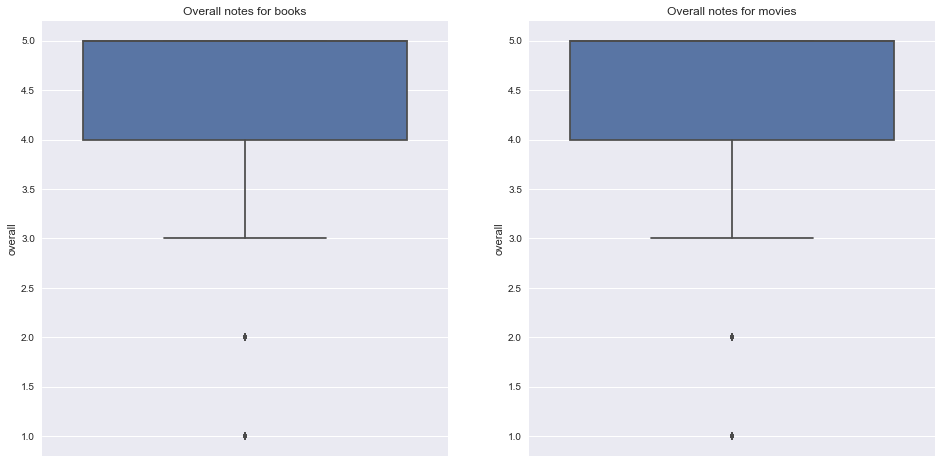

In [33]:
sb.set(style="darkgrid")
zone, (plot1, plot2) = plt.subplots(ncols=2)
zone.set_size_inches(16, 8)

plot1 = sb.boxplot(y = 'overall' , data=books_df, ax = plot1)
plot1.set_title("Overall notes for books")

plot2 = sb.boxplot(y = 'overall' , data=movies_df, ax = plot2)
plot2.set_title("Overall notes for movies")

The values we plotted above allow us to vizualize what we have concluded previously (using `describe`) about the overall scores but does not bring much new insight.

It could be interesting to compare the overall score of our filtered data (restrained to product that are available on multiple platforms) against the overall score of all the products.

Overall notes for books before and after filtering : 4.2957 and 4.276006565143417, difference of 0.46055670300221835%
Overall notes for movies before and after filtering : 4.1868 and 4.16540813512254, difference of 0.5135598765721068%


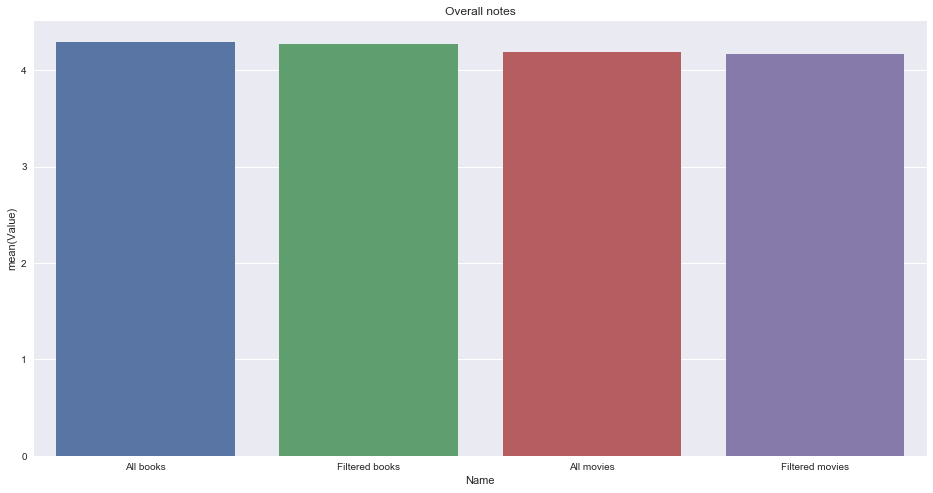

In [34]:
temp_df_plot = pd.DataFrame([["All books",4.2957],["Filtered books",books_df['overall'].mean()],["All movies",4.1868],["Filtered movies",movies_df["overall"].mean()]],columns=["Name","Value"])
zone, plot = plt.subplots(ncols=1, sharey=True)
zone.set_size_inches(16, 8)
plot = sb.barplot(x="Name", y="Value", data=temp_df_plot)
plot.set_title("Overall notes")
print(f"Overall notes for books before and after filtering : {4.2957} and {books_df['overall'].mean()}, difference of {100*(4.2957-books_df['overall'].mean())/books_df['overall'].mean()}%")
print(f"Overall notes for movies before and after filtering : {4.1868} and {movies_df['overall'].mean()}, difference of {100*(4.1868-movies_df['overall'].mean())/movies_df['overall'].mean()}%")

This could be interesting: with the plot above we see a larger difference for movies than for books. It means that movies that are created from books tend to have worse overall scores compared to other movies. This effect is less pronunced for books.

We will make some plot to show any correlation between overall notes and other features, however we won't spend so much time for this analysis as it does not have a strong impact for our study. To make the plot readable we will take a 10% sample from each dataframe

In [35]:
def plotCor(df1,df2,y,x,title):
    zone, (plot1, plot2) = plt.subplots(ncols=2)
    zone.set_size_inches(16, 6)

    plot1 = sb.regplot(y =y,x=x, data=df1, ax = plot1,x_bins=10)
    plot1.set_title(title +" for movies")

    plot2 = sb.regplot(y =y ,x= x, data=df2, ax = plot2,x_bins=10)
    plot2.set_title(title + " for books") 

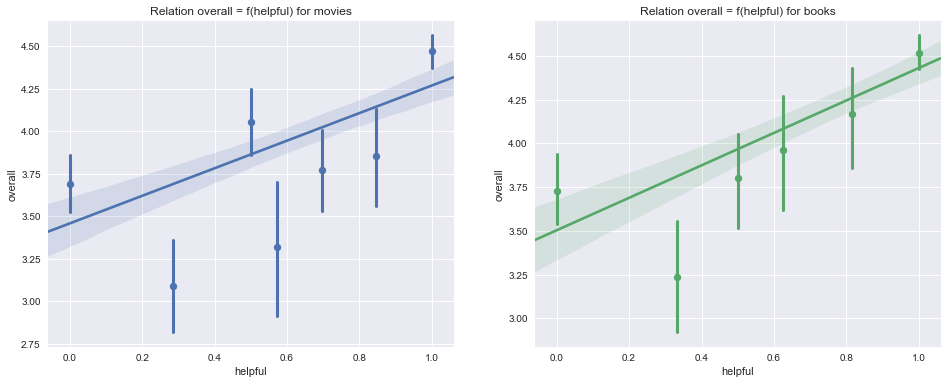

In [36]:
sample_movies = movies_df.sample(frac=0.01)
sample_movies['desc_length']=sample_movies["description"].str.len()
sample_movies['review_length']=sample_movies["reviewText"].str.len()
sample_books = books_df.sample(frac = 0.01)
sample_books['desc_length']=sample_books["description"].str.len()
sample_books['review_length']=sample_books["reviewText"].str.len()

plotCor(sample_movies,sample_books,"overall","helpful","Relation overall = f(helpful)")

For movies, the overall score seem to not be related to the helpfulness of the comment. On the over hand, we see a slight correlation for books: the most helpful comments are also the ones of of the reviews giving the highest overall score.

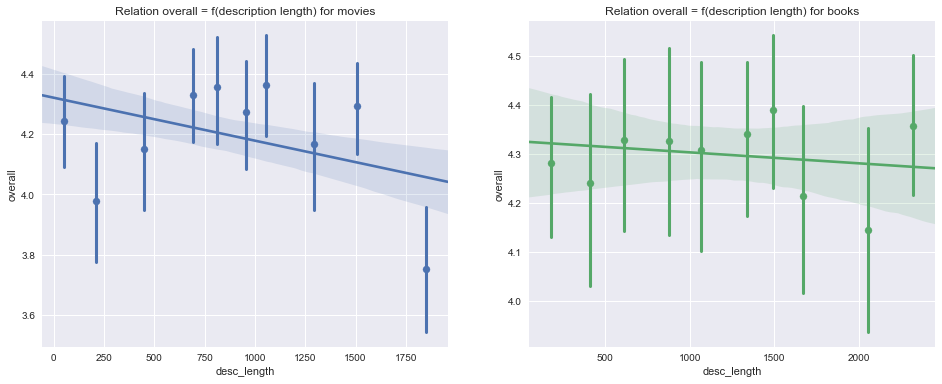

In [37]:
plotCor(sample_movies,sample_books,"overall","desc_length","Relation overall = f(description length)")

The description length does not seem to have a high influence of how the user rated the product.

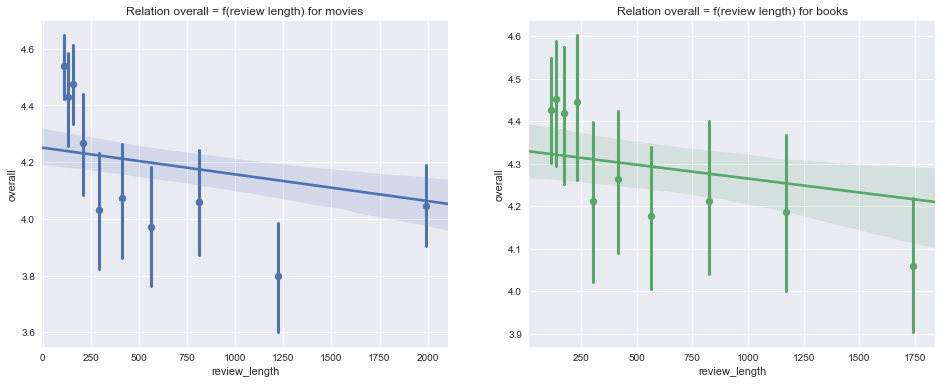

In [38]:
plotCor(sample_movies,sample_books,"overall","review_length","Relation overall = f(review length)")

Similarly, the summaray length is not linearly correlated to the overall score.

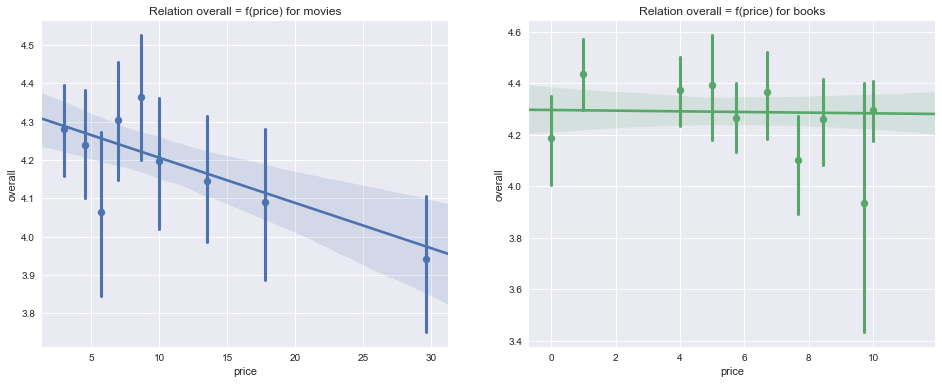

In [39]:
plotCor(sample_movies,sample_books,"overall","price","Relation overall = f(price)")

In both cases, we notice a slight correlation between the cost and the score: the more expensive the product is, the lower the score. Still, there is a high variance in the data so this should not be taken as a rule.

## Analysis with matching

In order to ease our different analysis we will add to each row an identifier wich corresponds to a certain franchise. This identifier will be the same for all books and movies products wich are linked to the same Intellual Property (IP).

In [40]:
asin_to_franchise_id = {}
franchise_id = 0

for raw_book_title, raw_movie_titles in book_title_to_movie_titles.items():
    clean_book_title = ada.matching.normalize_title(raw_book_title)
    if clean_book_title not in title_to_book_metas:
        continue
        
    has_match = False
        
    for raw_movie_title in raw_movie_titles:
        clean_movie_title = ada.matching.normalize_title(raw_movie_title)
        if clean_movie_title not in title_to_movie_metas:
            continue
            
        has_match = True
        for movie_meta in title_to_movie_metas[clean_movie_title]:
            movie_asin = movie_meta["asin"]
            asin_to_franchise_id[movie_asin] = franchise_id
    
    if has_match:
        for book_meta in title_to_book_metas[clean_book_title]:
            book_asin = book_meta["asin"]
            asin_to_franchise_id[book_asin] = franchise_id
        franchise_id += 1



print(f"Number of asin values: {len(asin_to_franchise_id)}")
print(f"Number of frachises: {franchise_id}")

Number of asin values: 5385
Number of frachises: 888


In [41]:
def add_franchise_id(df, asin_to_franchise_id):
    df['franchise_id'] = df['asin'].apply(lambda x: asin_to_franchise_id[x] if x in asin_to_franchise_id else None)


In [42]:
add_franchise_id(books_df, asin_to_franchise_id)
add_franchise_id(movies_df, asin_to_franchise_id)
books_df.to_json(data.get_path("merged_clean_Books", use_gzip=False), orient='records')
movies_df.to_json(data.get_path("merged_clean_Movies", use_gzip=False), orient='records')

In [43]:
# Reload the files from disk, so you can execute the notebook from this point without running the previous cells
books_df = pd.read_json(data.get_path("merged_clean_Books", use_gzip=False), orient="records")
movies_df = pd.read_json(data.get_path("merged_clean_Movies", use_gzip=False), orient="records")

In [44]:
books_df.head(5)

,asin,description,franchise_id,helpful,overall,price,reviewText,reviewerID,summary,title,unixReviewTime
0,0001472933,None,126,NaN,5,26.55,I attended an in depth study on Daniel last Fa...,AFA85QZQS1NKX,Great read.,The Book of Daniel,1375401600
1,0001472933,None,126,1.000000,5,26.55,This book contains information which would hel...,ARFK2WYVYT1QQ,The book of Daniel,The Book of Daniel,1347321600
2,0001472933,None,126,0.777778,5,26.55,This is a classic Larkin book great for Bible ...,A1O5WPLJSI7Y1B,The Book of Daniel,The Book of Daniel,1233532800
3,0001472933,None,126,NaN,5,26.55,"Book in like-new condition, I paid a total aro...",A1ABJCJ06H9363,but worth of your time to finish these 250 pag...,The Book of Daniel,1404345600
4,0001472933,None,126,0.750000,5,26.55,The Best explanation and Exposition of the Boo...,AO93WR5UAFA6F,The Book of Daniel,The Book of Daniel,1247788800


In [45]:
movies_df.head(5)

,asin,brand,description,franchise_id,helpful,overall,price,reviewText,reviewerID,summary,title,unixReviewTime
0,0738921947,,"In this animated prequel toThe Wizard of Oz, t...",876,0.25,3,1.75,this is from the series of books that spawned ...,A32JKNQ6BABMQ2,another good wizard of oz film.wheres the rest?,Lion of Oz [VHS],1094774400
1,0738921947,,"In this animated prequel toThe Wizard of Oz, t...",876,0.00,1,1.75,I had an old tape (for VCR) of this movie and ...,A1VHW4P1DBIQ4T,this is the worst movie ever...,Lion of Oz [VHS],1280534400
2,0738921947,,"In this animated prequel toThe Wizard of Oz, t...",876,1.00,2,1.75,Corny songs that seem forced bad voice actors ...,A3OFK5M629L9WK,good for 7 and under,Lion of Oz [VHS],1401840000
3,0738921947,,"In this animated prequel toThe Wizard of Oz, t...",876,NaN,3,1.75,Definitely for children of a certain age: 5-10...,ALH5ICRHO43PV,The Lion Of Oz...,Lion of Oz [VHS],1333238400
4,0738921947,,"In this animated prequel toThe Wizard of Oz, t...",876,NaN,4,1.75,"Roger S. Baum, the great-grandson of L. Frank ...",A26O0T192IBKY1,Enjoyable Oz cartoon,Lion of Oz [VHS],1263081600


In [46]:
print(len(books_df['asin'].unique()))
print(len(movies_df['asin'].unique()))

3509
1535


Let's try to see if the same users gave reviews for both movies and books and then if we have some users that gave reviews for a pair movie/book

In [47]:
# Find the `reviewerID` of users who reviewed both movies and books (not necessarily from the same franchise)
movies_users = movies_df['reviewerID'].unique()
books_users = books_df['reviewerID'].unique()
users_both = np.intersect1d(movies_users,books_users)
len(users_both)

8793

In [48]:
# Find the `reviewerID` of users who reviewed movies and books from the same franchise.
user_same_franchise = []
with ProgressBar(len(users_both)) as progress_bar:
    for user in users_both:
        movies_reviews_fr = movies_df[movies_df["reviewerID"]==user]["franchise_id"].unique()
        books_reviews_fr = books_df[books_df["reviewerID"]==user]["franchise_id"].unique()
        if len(np.intersect1d(movies_reviews_fr,books_reviews_fr))>0:
            user_same_franchise.append({"user":user,"franchises":np.intersect1d(movies_reviews_fr,books_reviews_fr)})
        progress_bar.update(1)

In [49]:
len(user_same_franchise)

1987

We have 1000 users which have given a review for both a movie and a book in the same franchise. This is a relatively small numbers and we will have to increase it for the next step but it should be enough for this milestone.
We also notice than nearly 1 over 4 person who gave a review for a movie and a book gave a review for a pair book/movie, wich is a big ratio

For each franchise, we will now compute the mean overall score of the books and movies. We'll keep everything in a new dataframe.

**We compute it only for the users who rated both books and movies for the same franchise.**

In [50]:
user_franchise_list = []
with ProgressBar(len(user_same_franchise)) as progress_bar:
    for user_dict in user_same_franchise:
        for fr in user_dict['franchises']:
            mov_mean = movies_df[(movies_df["reviewerID"]==user_dict['user']) & (movies_df["franchise_id"]==fr)]["overall"].mean()
            book_mean = books_df[(books_df["reviewerID"]==user_dict['user']) & (books_df["franchise_id"]==fr)]["overall"].mean()
            user_franchise_list.append([fr,book_mean,mov_mean])
        progress_bar.update(1)
user_franchise_df = pd.DataFrame(user_franchise_list,columns=["franchise_id","book_overall","movie_overall"])

user_franchise_df.head(5)

,franchise_id,book_overall,movie_overall
0,842,5.0,4.0
1,878,2.0,4.0
2,186,5.0,5.0
3,508,5.0,5.0
4,266,4.0,2.0


In [51]:
user_franchise_df.describe()

,franchise_id,book_overall,movie_overall
count,2801.000000,2801.000000,2801.000000
mean,468.946448,4.523723,4.107456
std,229.297014,0.867778,1.183559
min,1.000000,1.000000,1.000000
25%,280.000000,4.000000,3.500000
50%,504.000000,5.000000,5.000000
75%,643.000000,5.000000,5.000000
max,887.000000,5.000000,5.000000


We can already see some differences when comparing products by franchise: the mean score for the books is `0.46` points higher, but we also notice that the scores of the movies have a higher variance.
The effect on the score for users having rated both products is still pretty strong.

We can plot this data to vizualize it:

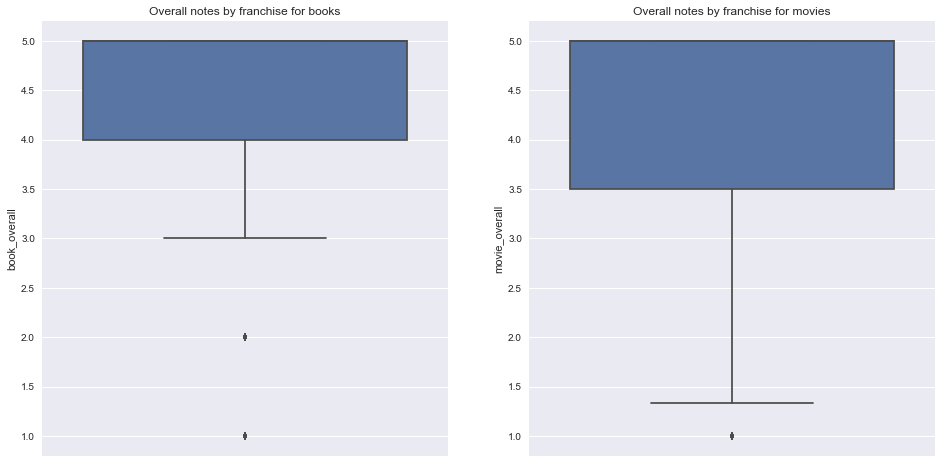

In [52]:
zone, (plot1, plot2) = plt.subplots(ncols=2)
zone.set_size_inches(16, 8)

plot1 = sb.boxplot(y = 'book_overall' , data=user_franchise_df, ax = plot1)
plot1.set_title("Overall notes by franchise for books")

plot2 = sb.boxplot(y = 'movie_overall' , data=user_franchise_df, ax = plot2)
plot2.set_title("Overall notes by franchise for movies")

The plot above helps to vizualize the difference observed previously: the books have higher scores and less variance.

In [53]:
# Number of franchises where the books has a higher mean score than the movies
better_movie_count = user_franchise_df[user_franchise_df["movie_overall"] > user_franchise_df["book_overall"]].shape[0]
better_book_count = user_franchise_df[user_franchise_df["book_overall"] > user_franchise_df["movie_overall"]].shape[0]
no_difference_count = user_franchise_df[user_franchise_df["book_overall"] == user_franchise_df["movie_overall"]].shape[0]
franchise_count = user_franchise_df.shape[0]

print(f"""
franchise_count: {franchise_count}
better_movie_count: {better_movie_count} ({100 * better_movie_count / franchise_count}%)
better_book_count: {better_book_count} ({100 * better_book_count / franchise_count}%)
no_difference_count: {no_difference_count} ({100 * no_difference_count / franchise_count}%)
""")


franchise_count: 2801
better_movie_count: 407 (14.53052481256694%)
better_book_count: 973 (34.73759371652981%)
no_difference_count: 1421 (50.73188147090325%)



When we only count individual differences in score, we also see that books tend to be better rated than movies. still, there is a large ratio (48%) where the mean score is roughly the same.

We will now run sentiment analysis on the review text.

In [54]:
analyser = SentimentIntensityAnalyzer()

In [55]:
movies_df['sentiment'] = movies_df['reviewText'].apply(lambda x: analyser.polarity_scores(x))

In [56]:
books_df['sentiment'] = books_df['reviewText'].apply(lambda x: analyser.polarity_scores(x))

In [57]:
def split_sentiment(x):
    """
    Split a dictionary of sentiment polarity into a serie.
    - `neg`: negative
    - `neu`: neutral
    - `pos`: positive
    - `compound`: compound
    """
    return pd.Series([x['neg'], x['neu'], x['pos'], x['compound']])

In [58]:
movies_df[['neg', 'neu', 'pos','compound']] = movies_df['sentiment'].apply(split_sentiment)
books_df[['neg', 'neu', 'pos','compound']] = books_df['sentiment'].apply(split_sentiment)
movies_df.head(5)

,asin,brand,description,franchise_id,helpful,overall,price,reviewText,reviewerID,summary,title,unixReviewTime,sentiment,neg,neu,pos,compound
0,0738921947,,"In this animated prequel toThe Wizard of Oz, t...",876,0.25,3,1.75,this is from the series of books that spawned ...,A32JKNQ6BABMQ2,another good wizard of oz film.wheres the rest?,Lion of Oz [VHS],1094774400,"{'neg': 0.083, 'neu': 0.805, 'pos': 0.112, 'co...",0.083,0.805,0.112,0.6270
1,0738921947,,"In this animated prequel toThe Wizard of Oz, t...",876,0.00,1,1.75,I had an old tape (for VCR) of this movie and ...,A1VHW4P1DBIQ4T,this is the worst movie ever...,Lion of Oz [VHS],1280534400,"{'neg': 0.047, 'neu': 0.846, 'pos': 0.107, 'co...",0.047,0.846,0.107,0.7118
2,0738921947,,"In this animated prequel toThe Wizard of Oz, t...",876,1.00,2,1.75,Corny songs that seem forced bad voice actors ...,A3OFK5M629L9WK,good for 7 and under,Lion of Oz [VHS],1401840000,"{'neg': 0.222, 'neu': 0.62, 'pos': 0.158, 'com...",0.222,0.620,0.158,-0.3632
3,0738921947,,"In this animated prequel toThe Wizard of Oz, t...",876,NaN,3,1.75,Definitely for children of a certain age: 5-10...,ALH5ICRHO43PV,The Lion Of Oz...,Lion of Oz [VHS],1333238400,"{'neg': 0.0, 'neu': 0.61, 'pos': 0.39, 'compou...",0.000,0.610,0.390,0.8225
4,0738921947,,"In this animated prequel toThe Wizard of Oz, t...",876,NaN,4,1.75,"Roger S. Baum, the great-grandson of L. Frank ...",A26O0T192IBKY1,Enjoyable Oz cartoon,Lion of Oz [VHS],1263081600,"{'neg': 0.092, 'neu': 0.79, 'pos': 0.118, 'com...",0.092,0.790,0.118,0.9192


Let's plot the correlation of the sentiment against the overall score to check how related the score and description are.

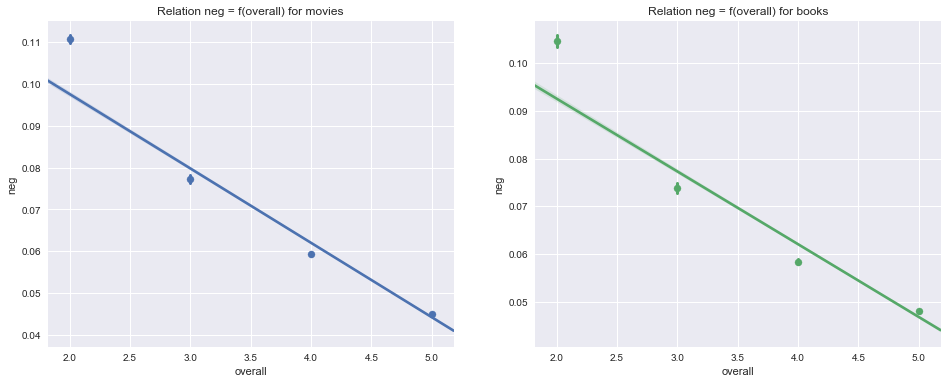

In [59]:
plotCor(movies_df,books_df,"neg","overall","Relation neg = f(overall)")

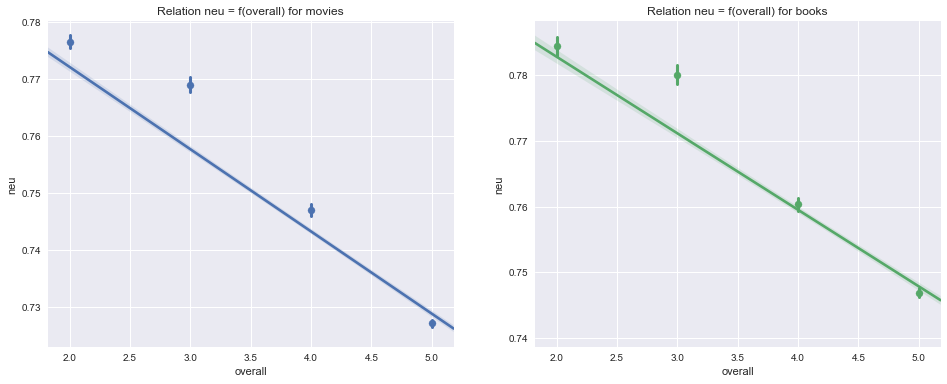

In [60]:
plotCor(movies_df,books_df,"neu","overall","Relation neu = f(overall)")

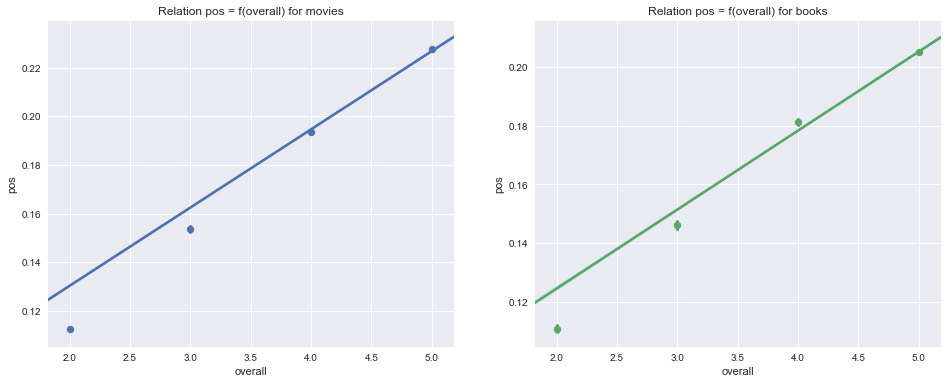

In [61]:
plotCor(movies_df,books_df,"pos","overall","Relation pos = f(overall)")

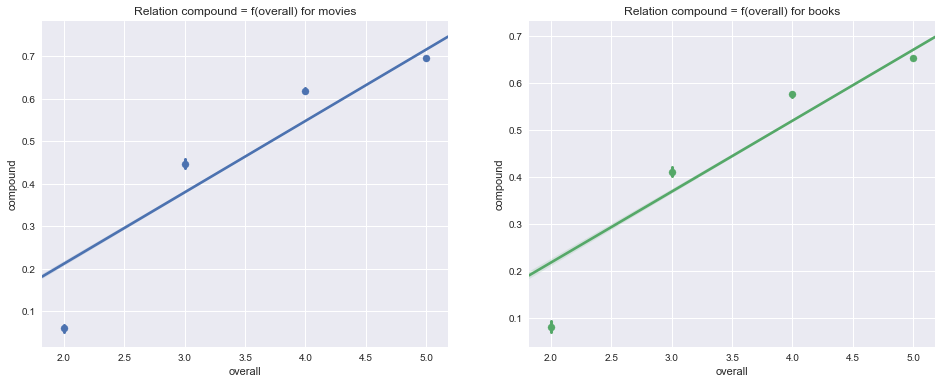

In [62]:
plotCor(movies_df,books_df,"compound","overall","Relation compound = f(overall)")

As expected, a good score has a negative correlation with negative sentiments and positive with positive sentiments. We notice that neutral comments behave like negative comment while compound comments are closer to positive comments.

From the documentation :

> The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.
> 
> It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:
> 
>       positive sentiment: compound score >= 0.5
>       neutral sentiment: (compound score > -0.5) and (compound score < 0.5)
>       negative sentiment: compound score <= -0.5
> 
> The pos, neu, and neg scores are ratios for proportions of text that fall in each category (so these should all add up to be 1... or close to it with float operation). These are the most useful metrics if you want multidimensional measures of sentiment for a given sentence.

We can try to take a look at the relation between time and the score. We'll just check with the franchise with id `1` and explore it more during the next milestone.

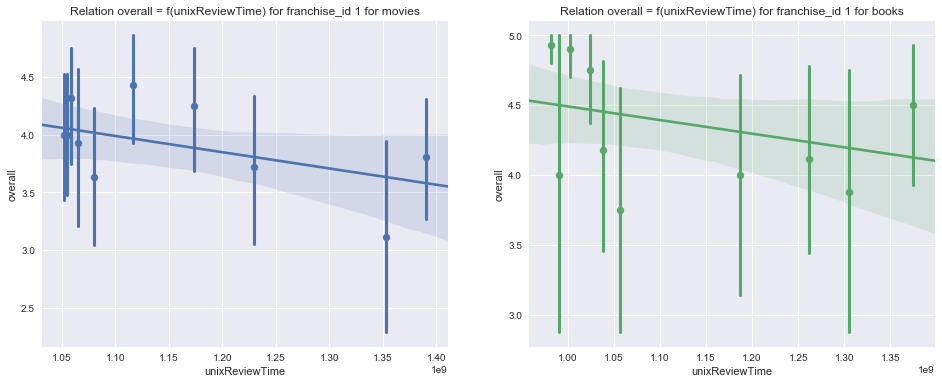

In [63]:
plotCor(movies_df[movies_df['franchise_id']==1],books_df[books_df["franchise_id"]==1],"overall","unixReviewTime","Relation overall = f(unixReviewTime) for franchise_id 1")

In this case, the score of the movie does not seem to depend on the time, while the book sees a slight increase. Since this is just one case with a lot of variance, we cannot conclude anything yet and will need to investigate it more.

# Milestone 3

# Analysis

We complete the analysis made in the previous milestone with more in depth and complete content. We did not change too much the data handling part, except the matching part with wikipedia ressources. We added a few more rules to the cleaning process of initial strings that allow us to match much more titles.

TODO : résumé

In [74]:
# Imports and constants
import pandas as pd
from ada import data
import numpy as np
from ada.progressbar import ProgressBar
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn import linear_model
from mlp_toolkits.mplot3d import Axes3D

ModuleNotFoundError: No module named 'mlp_toolkits'

In [65]:
# We load previously saved files containing the filtered and clean data
books_df = pd.read_json(data.get_path(
    "merged_clean_Books", use_gzip=False), orient="records")
movies_df = pd.read_json(data.get_path(
    "merged_clean_Movies", use_gzip=False), orient="records")

In [66]:
# Helpers
def split_sentiment(x):
    """
    Split a dictionary of sentiment polarity into a serie.
    - `neg`: negative
    - `neu`: neutral
    - `pos`: positive
    - `compound`: compound
    """
    return pd.Series([x['neg'], x['neu'], x['pos'], x['compound']])

def plotCor(df1, df2, y, x, title, suffixa=" for movies", suffixb=" for books"):
    """
    Plot 2 regplots side by sidethat share x and y axis with 10 bins on each
    """
    zone, (plot1, plot2) = plt.subplots(ncols=2, sharey=True, sharex=True)
    zone.set_size_inches(16, 6)

    plot1 = sb.regplot(y=y, x=x, data=df1, ax=plot1, x_bins=10)
    plot1.set_title(title + suffixa)

    plot2 = sb.regplot(y=y, x=x, data=df2, ax=plot2, x_bins=10)
    plot2.set_title(title + suffixb)
    plt.show()

def normalizeColumn(df, columns):
    """
    Normalize a list of columns between 0 and 1 and return the modified
    dataframe. 
    """
    for column in columns:
        df[column] = (df[column] - df[column].min()) / \
            (df[column].max() - df[column].min())
    return df

def plot_impact_time(df,groupby, main_col):
    """
    Compute a new dataframe containing the number of occurence of reviews made for a book before/after/the same day 
    than the review made for a movie for the same franchise by the same user. 
    Show a barplot of this new dataframe
    """
    time_impact_df_bf = df.groupby(groupby)[["unixReviewTime_movies", "unixReviewTime_books"]].apply(
        lambda x: x[x["unixReviewTime_movies"] > x["unixReviewTime_books"]].count() / x.shape[0])
    time_impact_df_bf = time_impact_df_bf.reset_index().drop(
        time_impact_df_bf.columns[len(time_impact_df_bf.columns) - 1], axis=1)
    time_impact_df_bf.columns = [main_col, "book before movie"]

    time_impact_df_at = df.groupby(groupby)[["unixReviewTime_movies", "unixReviewTime_books"]].apply(
        lambda x: x[x["unixReviewTime_movies"] < x["unixReviewTime_books"]].count() / x.shape[0])
    time_impact_df_at = time_impact_df_at.reset_index().drop(
        time_impact_df_at.columns[len(time_impact_df_at.columns) - 1], axis=1)
    time_impact_df_at.columns = [main_col, "book after movie"]

    time_impact_df_se = df.groupby(groupby)[["unixReviewTime_movies", "unixReviewTime_books"]].apply(
        lambda x: x[x["unixReviewTime_movies"] == x["unixReviewTime_books"]].count() / x.shape[0])
    time_impact_df_se = time_impact_df_se.reset_index().drop(
        time_impact_df_se.columns[len(time_impact_df_se.columns) - 1], axis=1)
    time_impact_df_se.columns = [main_col, "book same day movie"]

    time_impact_df = time_impact_df_bf.merge(
        time_impact_df_at).merge(time_impact_df_se)
    time_impact_df.plot(kind="bar", x=main_col)
    plt.show()
    
def same_plot_bar(dflist, namelist, xlegend):
    """
    Show a single bar plot for a list of dataframe which share the same columns
    This plot allow a good comparison between them. Colors are the default ones of matplotlib
    """
    pos = list(range(len(dflist[0].mean())))
    width = 1.0 / (1 + len(dflist))
    fig, ax = plt.subplots(figsize=(16, 8))
    for numb, df in enumerate(dflist):
        plt.bar([p + numb * width for p in pos],
                df.mean(),
                width,
                color='C' + str(numb),
                yerr=df.std())

    ax.set_xticks([p + len(dflist) * 0.25 * width for p in pos])
    ax.set_xticklabels(xlegend)
    plt.legend(namelist, loc='upper left')
    plt.axhline(0, color='black')
    plt.show()

We will compute a sentiment analysis for all reviews using the `vaderSentiment` package, as this package give a good analysis without too much overhead. We will mainly use the `compound` value, which is according to the documentation :
>the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. 
>Calling it a 'normalized, weighted composite score' is accurate.

In [67]:
analyser = SentimentIntensityAnalyzer()
movies_df['sentiment'] = movies_df['reviewText'].apply(
    lambda x: analyser.polarity_scores(x))
books_df['sentiment'] = books_df['reviewText'].apply(
    lambda x: analyser.polarity_scores(x))
books_df.head()

,asin,description,franchise_id,helpful,overall,price,reviewText,reviewerID,summary,title,unixReviewTime,sentiment
0,0001472933,None,126,NaN,5,26.55,I attended an in depth study on Daniel last Fa...,AFA85QZQS1NKX,Great read.,The Book of Daniel,1375401600,"{'neg': 0.0, 'neu': 0.618, 'pos': 0.382, 'comp..."
1,0001472933,None,126,1.000000,5,26.55,This book contains information which would hel...,ARFK2WYVYT1QQ,The book of Daniel,The Book of Daniel,1347321600,"{'neg': 0.056, 'neu': 0.691, 'pos': 0.254, 'co..."
2,0001472933,None,126,0.777778,5,26.55,This is a classic Larkin book great for Bible ...,A1O5WPLJSI7Y1B,The Book of Daniel,The Book of Daniel,1233532800,"{'neg': 0.0, 'neu': 0.66, 'pos': 0.34, 'compou..."
3,0001472933,None,126,NaN,5,26.55,"Book in like-new condition, I paid a total aro...",A1ABJCJ06H9363,but worth of your time to finish these 250 pag...,The Book of Daniel,1404345600,"{'neg': 0.0, 'neu': 0.807, 'pos': 0.193, 'comp..."
4,0001472933,None,126,0.750000,5,26.55,The Best explanation and Exposition of the Boo...,AO93WR5UAFA6F,The Book of Daniel,The Book of Daniel,1247788800,"{'neg': 0.0, 'neu': 0.826, 'pos': 0.174, 'comp..."


In [68]:
movies_df[['neg', 'neu', 'pos', 'compound']
          ] = movies_df['sentiment'].apply(split_sentiment)
books_df[['neg', 'neu', 'pos', 'compound']
         ] = books_df['sentiment'].apply(split_sentiment)

print(len(books_df['asin'].unique()))
print(len(movies_df['asin'].unique()))

3509
1535


We will first filter the previous data to keep only reviews made by people who reviewed both a movie and a book of the same franchise. This will allow us to have a concrete comparison, without the bias inherent to the book/movie rating.

In [69]:
# Filter the users who gave reviews for a pair
movies_users = movies_df['reviewerID'].unique()
books_users = books_df['reviewerID'].unique()
users_both = np.intersect1d(movies_users, books_users)
len(users_both)

user_same_franchise = []
with ProgressBar(len(users_both)) as progress_bar:
    for user in users_both:
        movies_reviews_fr = movies_df[movies_df["reviewerID"]
                                      == user]["franchise_id"].unique()
        books_reviews_fr = books_df[books_df["reviewerID"]
                                    == user]["franchise_id"].unique()
        if len(np.intersect1d(movies_reviews_fr, books_reviews_fr)) > 0:
            user_same_franchise.append({"user": user, "franchises": np.intersect1d(
                movies_reviews_fr, books_reviews_fr)})
        progress_bar.update(1)

len(user_same_franchise)

1987

In [71]:
# Filter the dataframes with these users
# Take only reviews made by these users for the pair, not all their reviews
mov_m = pd.DataFrame()
book_m = pd.DataFrame()
with ProgressBar(len(user_same_franchise)) as progress_bar:
    for user_dict in user_same_franchise:
        for fr in user_dict['franchises']:
            mov_m = mov_m.append(movies_df[(movies_df["reviewerID"] == user_dict['user']) & (
                movies_df["franchise_id"] == fr)])

            book_m = book_m.append(books_df[(books_df["reviewerID"] == user_dict['user']) & (
                books_df["franchise_id"] == fr)])
        progress_bar.update(1)

We now merge both dataframes (movies and books) so in a single row we have both reviews for a same pair for a single user, we will also normalize key features sucha as score or compound

In [72]:
# Merge the dataframes with reviewerID and franchiseID as keys
merged_df = mov_m.merge(book_m, on=["reviewerID", "franchise_id"],
                        suffixes=["_movies", "_books"])
merged_df = merged_df[['asin_movies', 'asin_books', 'reviewerID', 'franchise_id', "overall_movies",  "neg_movies", "neu_movies",
                       "pos_movies", "compound_movies", "overall_books", "neg_books", "neu_books", "pos_books", "compound_books", "unixReviewTime_books", "unixReviewTime_movies"]]
merged_df = normalizeColumn(
    merged_df, ["overall_movies", "overall_books", "compound_movies", "compound_books"])
merged_df.head(5)

,asin_movies,asin_books,reviewerID,franchise_id,overall_movies,neg_movies,neu_movies,pos_movies,compound_movies,overall_books,neg_books,neu_books,pos_books,compound_books,unixReviewTime_books,unixReviewTime_movies
0,6300215539,0141441038,A106016KSI0YQ,842,0.75,0.077,0.790,0.133,0.940870,1.00,0.136,0.776,0.088,0.037877,1118188800,1095292800
1,0792845986,0062008110,A1072Q1O6YB3NY,878,0.75,0.000,0.902,0.098,0.690795,0.25,0.037,0.876,0.087,0.721255,1363305600,1363478400
2,0790701022,0393089134,A107UOX7KZHZLB,186,1.00,0.000,0.831,0.169,0.899300,1.00,0.108,0.722,0.169,0.699239,953769600,953769600
3,B00003CWT6,0007124015,A108A421PC6MH3,508,1.00,0.050,0.789,0.161,0.994547,1.00,0.067,0.792,0.140,0.974082,1019606400,1037145600
4,B000053V8F,0340839937,A108IFSXYNF1E,266,0.25,0.028,0.795,0.178,0.972886,0.75,0.025,0.907,0.069,0.716351,996969600,997056000


We will try to define categories of users behaviors related to the reviewing process of a pair movie/book. We will use a kmean clustering with 5 clusters, as it seems to be the more relevant in our case

[[ 0.93636894  0.91783421  0.94198366  0.93588691]
 [ 0.53560127  0.84731013  0.15726819  0.9055543 ]
 [ 0.79431217  0.8260582   0.92778717  0.15279664]
 [ 0.3490364   0.84047109  0.91388649  0.91706464]
 [ 0.68965517  0.84482759  0.11680298  0.10659777]]


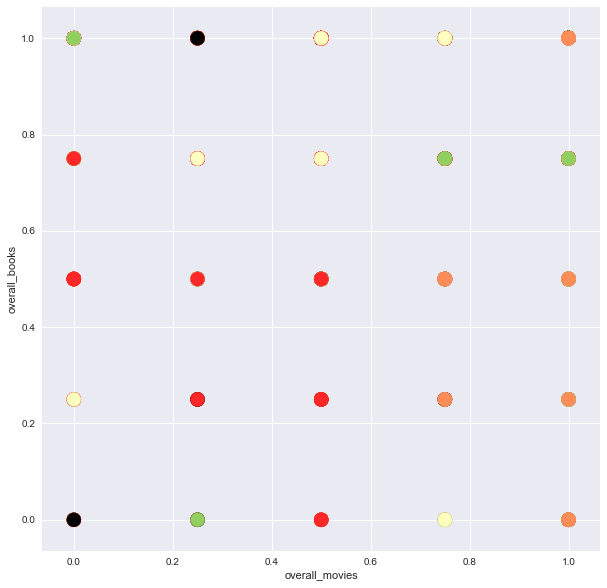

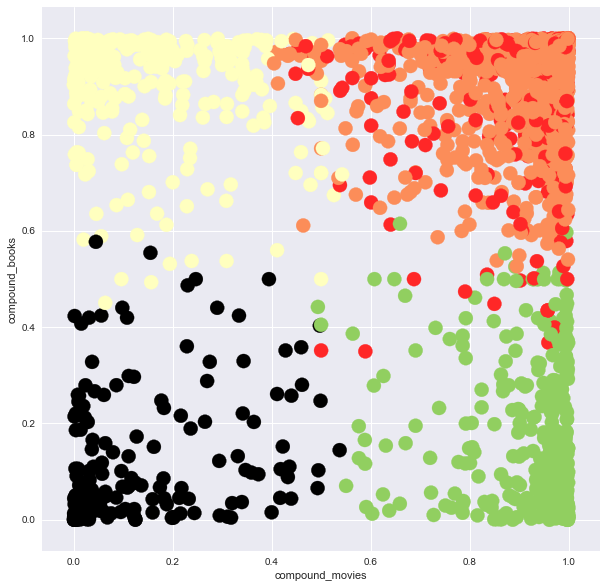

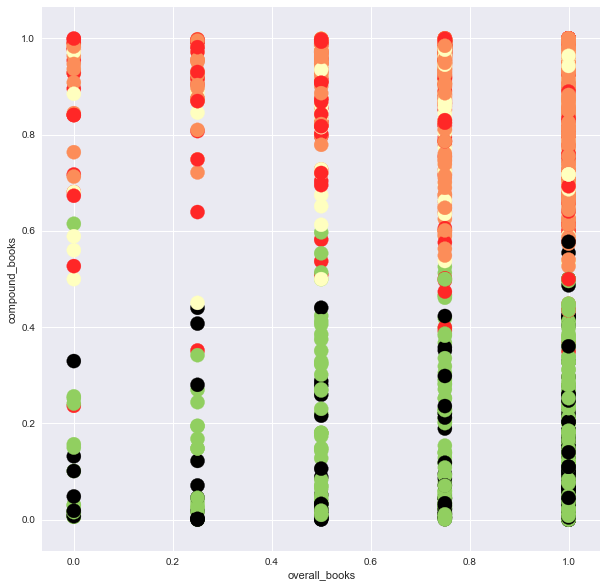

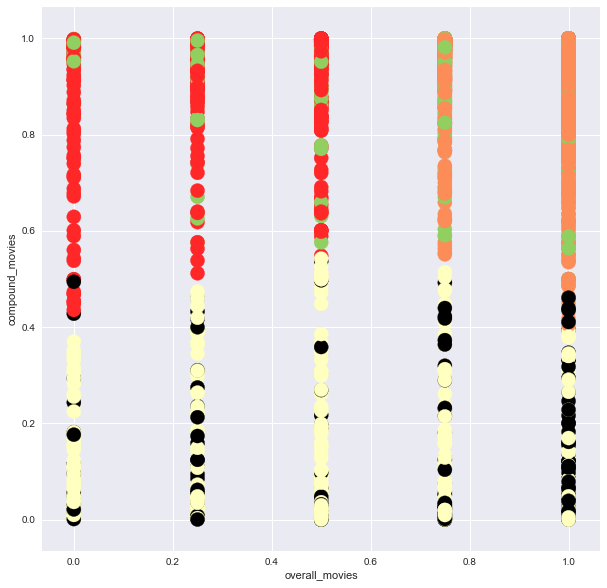

ValueError: Unknown projection '3d'

In [73]:
merged_df_fil = merged_df[["overall_movies", "overall_books", "compound_movies", "compound_books"]]

npdf = merged_df_fil.values

kmeans = KMeans(n_clusters=5, random_state=100).fit(npdf)
print(kmeans.cluster_centers_)
# Cluster 0 : good grades and reviews for movies and books
# Cluster 1 : Bad review and bad grade for movies, good review and grade for books
# Cluster 2 : Generally good but negative reviews for books
# Cluster 3 : Bad grade for movies
# Cluster 4 : Bad reviews for both movies and books
kmeans_df = pd.DataFrame(np.c_[npdf, kmeans.labels_, merged_df["reviewerID"].values], columns=[
    "overall_movies", "overall_books", "compound_movies", "compound_books", "cluster", "reviewerID"])
color_dict = {0.0: "#fc8d59", 1.0: "#ffffbf",
              2.0: "#91cf60", 3.0: "#ff2727", 4.0: "#000000"}
kmeans_df["color"] = kmeans_df["cluster"].map(color_dict)
kmeans_df.head()

# sb.regplot(data=kmeans_df, x="overall_movies", y="overall_books",
#             scatter_kws={'c': kmeans_df['color']})
# plt.show()
scatterplot = kmeans_df.plot.scatter(
    x="overall_movies", y="overall_books", figsize=(10, 10), c=kmeans_df['color'], s=200)
plt.show()
scatterplot = kmeans_df.plot.scatter(
    x="compound_movies", y="compound_books", figsize=(10, 10), c=kmeans_df['color'], s=200)
plt.show()
scatterplot = kmeans_df.plot.scatter(
    x="overall_books", y="compound_books", figsize=(10, 10), c=kmeans_df['color'], s=200)
plt.show()
scatterplot = kmeans_df.plot.scatter(
    x="overall_movies", y="compound_movies", figsize=(10, 10), c=kmeans_df['color'], s=200)
plt.show()

threedee = plt.figure().gca(projection='3d')
threedee.scatter(kmeans_df["overall_books"],
                 kmeans_df["compound_books"], kmeans_df["overall_movies"], c=kmeans_df['color'])
threedee.set_xlabel('Overall score for books')
threedee.set_ylabel('Sentiment for books')
threedee.set_zlabel('Overall score for movies')
plt.show()


In [ ]:
TODO : remove some plots, re analyze clusters meaning 

## Do people who give many reviews always belong to the same cluster ? 

In [ ]:
kmeans_df[kmeans_df.duplicated(subset=[
    "overall_movies", "overall_books", "compound_movies", "compound_books"], keep=False)]
# Note that we have some duplicates, when looking at the reviews and products it is
# just that often a same user copy paste its review for 2 distinct products

multi_rating = kmeans_df[kmeans_df.duplicated(
    subset=["reviewerID"], keep=False)]
# 38% of reviews are made by people who gave more than one review
multi_rating.shape[0] / kmeans_df.shape[0]
multi_rating_gb = pd.DataFrame()
multi_rating_gb["unique"] = multi_rating.groupby(["reviewerID"])[
    "cluster"].nunique()
multi_rating_gb["total"] = multi_rating.groupby(["reviewerID"])[
    "cluster"].count()
multi_rating_gb = multi_rating_gb.reset_index()
multi_rating_gb.plot.scatter(
    x="total", y="unique", figsize=(10, 10))
plt.show()

list_user_unique_cluster = multi_rating_gb[multi_rating_gb["unique"] == 1]["reviewerID"].tolist(
)
multi_rating[multi_rating["reviewerID"].isin(
    list_user_unique_cluster)].groupby(["cluster"])["reviewerID"].nunique().plot(kind="bar")
plt.show()



We can see a big majority for cluster 0:
People who give good grades and reviews for both movies and books in a review tend to do the same for all franchises

TODO, recompute percentage and maybe change analysis

Do the worst/better grades and reviews mention the book/movie ? 

In [ ]:
mov_m_with_b = mov_m[mov_m["reviewText"].str.contains("book|read")]
mov_m_with_b.shape[0] / mov_m.shape[0]
book_m_with_b = book_m[book_m["reviewText"].str.contains("film|movie")]
book_m_with_b.shape[0] / book_m.shape[0]
# We have tried more complex combination but it is not realy accurate, for example if we add the word "see" for the books we add
# many reviews but by looking at them we can see that it is not really relevant
mov_m_with_b.describe()
book_m_with_b.describe()
plotCor(mov_m_with_b, mov_m, y="neg", x="overall", title="Negativity function of score",
        suffixa=" for reviews speaking of the book", suffixb=" for any review")
plotCor(mov_m_with_b, mov_m, y="pos", x="overall", title="Positivity function of score",
        suffixa=" for reviews speaking of the book", suffixb=" for any review")

plotCor(book_m_with_b, book_m, y="neg", x="overall", title="Negativity function of score ",
        suffixa=" for reviews speaking of the movie", suffixb=" for any review")
plotCor(book_m_with_b, book_m, y="pos", x="overall", title="Positivity function of score",
        suffixa=" for reviews speaking of the movie", suffixb=" for any review")


# Let"s also see which percentage contains those reference for each grade
mov_m["reference_book"] = mov_m["reviewText"].str.contains(
    "book|read").astype(int)
mov_m.head()
book_m["reference_movie"] = book_m["reviewText"].str.contains(
    "film|movie").astype(int)
mov_m_gb_ref = mov_m.groupby(['overall']).agg({'reference_book': 'sum'})[
    "reference_book"] / mov_m.groupby(['overall']).agg({'reference_book': 'count'})["reference_book"]
mov_m_gb_ref.plot(kind='bar')
plt.show()
book_m_gb_ref = book_m.groupby(['overall']).agg({'reference_movie': 'sum'})[
    "reference_movie"] / book_m.groupby(['overall']).agg({'reference_movie': 'count'})["reference_movie"]
book_m_gb_ref.plot(kind='bar')
plt.show()
cutSpace = np.linspace(-1, 1, 21)
mov_m_sent_ref = mov_m.groupby(pd.cut(mov_m["compound"], cutSpace)).agg({'reference_book': 'sum'})[
    "reference_book"] / mov_m.groupby(pd.cut(mov_m["compound"], cutSpace)).agg({'reference_book': 'count'})["reference_book"]
book_m_sent_ref = book_m.groupby(pd.cut(book_m["compound"], cutSpace)).agg({'reference_movie': 'sum'})[
    "reference_movie"] / book_m.groupby(pd.cut(book_m["compound"], cutSpace)).agg({'reference_movie': 'count'})["reference_movie"]
mov_m_sent_ref.plot(kind="bar")
plt.show()
book_m_sent_ref.plot(kind="bar")
plt.show()

Impact of the time: does reading the book before seing the movie as an impact ? 

In [ ]:
books_bf_movies = merged_df[merged_df["unixReviewTime_books"]
                            < merged_df["unixReviewTime_movies"]]
books_at_movies = merged_df[merged_df["unixReviewTime_books"]
                            > merged_df["unixReviewTime_movies"]]
books_se_movies = merged_df[merged_df["unixReviewTime_books"]
                            == merged_df["unixReviewTime_movies"]]

print(f"Review for book before review for movie : {100 * books_bf_movies.shape[0]/merged_df.shape[0]} %")
print(f"Review for movie before review for book : {100 * books_at_movies.shape[0]/merged_df.shape[0]} %")
print(f"Reviews the same day : {100 * books_se_movies.shape[0]/merged_df.shape[0]} %")
result_time_df = pd.DataFrame(columns=["Context", "Mean books", "Mean movies", "Mean compound_books",
                                       "Mean compound_movies", "std books", "std_movies", "std comp books", "std comp movies"])
result_time_df.loc[0] = ["Book before movie", books_bf_movies["overall_books"].mean(), books_bf_movies["overall_movies"].mean(), books_bf_movies["compound_books"].mean(), books_bf_movies["compound_movies"].mean(),
                         books_bf_movies["overall_books"].std(), books_bf_movies["overall_movies"].std(), books_bf_movies["compound_books"].std(), books_bf_movies["compound_movies"].std()]
result_time_df.loc[1] = ["Book before movie", books_at_movies["overall_books"].mean(), books_at_movies["overall_movies"].mean(), books_at_movies["compound_books"].mean(), books_at_movies["compound_movies"].mean(),
                         books_at_movies["overall_books"].std(), books_at_movies["overall_movies"].std(), books_at_movies["compound_books"].std(), books_at_movies["compound_movies"].std()]
result_time_df.loc[2] = ["Book before movie", books_se_movies["overall_books"].mean(), books_se_movies["overall_movies"].mean(), books_se_movies["compound_books"].mean(), books_se_movies["compound_movies"].mean(),
                         books_se_movies["overall_books"].std(), books_se_movies["overall_movies"].std(), books_se_movies["compound_books"].std(), books_se_movies["compound_movies"].std()]
result_time_df

zone, (plot1, plot2, plot3) = plt.subplots(ncols=3)
zone.set_size_inches(16, 8)

plot1 = sb.boxplot(y='overall_books', data=books_bf_movies, ax=plot1)
plot1.set_title("Overall grades for books(book before movie)")

plot2 = sb.boxplot(y='overall_books', data=books_at_movies, ax=plot2)
plot2.set_title("Overall grades for books(book after movie)")

plot3 = sb.boxplot(y='overall_books', data=books_se_movies, ax=plot3)
plot3.set_title("Overall grades for books(book same movie)")
plt.show()

# Let's try to see if there is a difference per grade
(books_bf_movies.groupby([books_bf_movies["overall_books"]])[
 "overall_books"].count() / books_bf_movies.shape[0]).plot(kind='bar')
plt.show()
(books_at_movies.groupby([books_at_movies["overall_books"]])[
 "overall_books"].count() / books_at_movies.shape[0]).plot(kind='bar')
plt.show()
(books_se_movies.groupby([books_se_movies["overall_books"]])[
 "overall_books"].count() / books_se_movies.shape[0]).plot(kind='bar')
plt.show()
plot_impact_time(merged_df,"overall_books", "overall_books")
plot_impact_time(merged_df,"overall_movies", "overall_movies")
plot_impact_time(merged_df,
    pd.cut(merged_df["compound_books"], np.linspace(-1, 1, 6)), "compound_books")
plot_impact_time(merged_df,
    pd.cut(merged_df["compound_movies"], np.linspace(-1, 1, 6)), "compound_movies")


Impact of the time : raw analysis on non filtered reviews

In [ ]:
movies_df.groupby(pd.cut(movies_df["unixReviewTime"], 10))["overall"].mean()
movies_df.groupby(pd.cut(movies_df["unixReviewTime"], 10))["overall"].std()
movies_df["dateTime"] = pd.to_datetime(
    movies_df["unixReviewTime"], unit="s", origin='unix')
movies_df.head()
errors = movies_df.resample('M', on="dateTime").std()
errors_overall = errors["overall"]
movies_df.resample('M', on="dateTime").mean().plot(
    y="overall", yerr=errors_overall)
plt.show()
errors_compound = errors["compound"]
movies_df.resample('M', on="dateTime").mean().plot(
    y="compound", yerr=errors_compound)
plt.show()

# Time for grades/reviews for books
books_df["dateTime"] = pd.to_datetime(
    books_df["unixReviewTime"], unit="s", origin='unix')
b_errors = books_df.resample('M', on="dateTime").std()
b_errors_overall = b_errors["overall"]
books_df.resample('M', on="dateTime").mean().plot(
    y="overall", yerr=b_errors_overall)
plt.show()
b_errors_compound = b_errors["compound"]
books_df.resample('M', on="dateTime").mean().plot(
    y="compound", yerr=errors_compound)
plt.show()

People buying all or a majority of products linked to the same franchise_id

In [ ]:
unique_per_fr = merged_df.groupby(["franchise_id"])[
    ["asin_books", "asin_movies"]].nunique()
unique_per_fr[unique_per_fr["asin_books"] + unique_per_fr["asin_movies"] > 2]
unique_per_user_per_fr = merged_df.groupby(["reviewerID", "franchise_id"])[
    ["asin_books", "asin_movies"]].nunique()
unique_per_user_per_fr[unique_per_user_per_fr["asin_books"] +
                       unique_per_user_per_fr["asin_movies"] > 2]
result_list_unique_fr = []
for fr_id in unique_per_fr.index:
    th = unique_per_fr.loc[fr_id]["asin_books"] + \
        unique_per_fr.loc[fr_id]["asin_movies"]

    temp = unique_per_user_per_fr.xs(fr_id, level='franchise_id')
    result_list_unique_fr += temp[(temp["asin_books"] +
                                   temp["asin_movies"]) > max(0.5 * th, 2)].index.tolist()


#  44 occurences of buying more than 50% of the franchise products
len(result_list_unique_fr)
len(set(result_list_unique_fr))

buy_everything_df = merged_df[merged_df["reviewerID"].isin(
    result_list_unique_fr)]
buy_everything_df.describe()
buy_everything_df[["overall_movies", "overall_books", "compound_movies", "compound_books"]].mean().plot.bar(
    yerr=buy_everything_df[["overall_movies", "overall_books", "compound_movies", "compound_books"]].std())
plt.show()
merged_df[["overall_movies", "overall_books", "compound_movies", "compound_books"]].mean().plot.bar(
    yerr=merged_df[["overall_movies", "overall_books", "compound_movies", "compound_books"]].std())
plt.show()
same_plot_bar([buy_everything_df[["overall_movies", "overall_books", "compound_movies", "compound_books"]], merged_df[[
              "overall_movies", "overall_books", "compound_movies", "compound_books"]]], ["Buy most", "All"], ["overall_movies", "overall_books", "compound_movies", "compound_books"])


Impact of the price

In [ ]:
plotCor(movies_df, books_df, "overall", "price",
        "Relation overall = f(price)")  # already done in milestone2
plotCor(movies_df, books_df, "compound", "price",
        "Relation compound = f(price)")
same_plot_bar([movies_df.groupby(pd.cut(movies_df["price"], np.linspace(0, 40, 11)))["overall"], books_df.groupby(
    pd.cut(books_df["price"], np.linspace(0, 40, 11)))["overall"]], ["movie grade", "book grade"], np.linspace(0, 40, 11))
same_plot_bar([movies_df.groupby(pd.cut(movies_df["price"], np.linspace(0, 40, 11)))["compound"], books_df.groupby(
    pd.cut(books_df["price"], np.linspace(0, 40, 11)))["compound"]], ["movie compound", "book compound"], np.linspace(0, 40, 11))
# Impact of the price for people who already buy other product of the franchise
plotCor(mov_m, book_m, "overall", "price",
        "Relation overall = f(price)")  # already done in milestone2
plotCor(mov_m, book_m, "compound", "price",
        "Relation compound = f(price)")
same_plot_bar([mov_m.groupby(pd.cut(mov_m["price"], np.linspace(0, 40, 11)))["overall"], book_m.groupby(
    pd.cut(book_m["price"], np.linspace(0, 40, 11)))["overall"]], ["movie grade", "book grade"], np.linspace(0, 40, 11))
same_plot_bar([mov_m.groupby(pd.cut(mov_m["price"], np.linspace(0, 40, 11)))["compound"], book_m.groupby(
    pd.cut(book_m["price"], np.linspace(0, 40, 11)))["compound"]], ["movie compound", "book compound"], np.linspace(0, 40, 11))


same_plot_bar([mov_m.groupby(pd.cut(mov_m["price"], np.linspace(0, 40, 11)))["overall"], movies_df.groupby(
    pd.cut(movies_df["price"], np.linspace(0, 40, 11)))["overall"]], ["movie grade filtered", "movie grade all"], np.linspace(0, 40, 11))
same_plot_bar([mov_m.groupby(pd.cut(mov_m["price"], np.linspace(0, 40, 11)))["compound"], movies_df.groupby(
    pd.cut(movies_df["price"], np.linspace(0, 40, 11)))["compound"]], ["movie compound filtered", "movie compound all"], np.linspace(0, 40, 11))

same_plot_bar([book_m.groupby(pd.cut(book_m["price"], np.linspace(0, 40, 11)))["overall"], books_df.groupby(
    pd.cut(books_df["price"], np.linspace(0, 40, 11)))["overall"]], ["book grade filtered", "book grade all"], np.linspace(0, 40, 11))
same_plot_bar([book_m.groupby(pd.cut(book_m["price"], np.linspace(0, 40, 11)))["compound"], books_df.groupby(
    pd.cut(books_df["price"], np.linspace(0, 40, 11)))["compound"]], ["book compound filtered", "book compound all"], np.linspace(0, 40, 11))


Impact of the product itself when there are more than one product for the same franchise

In [ ]:
groupby_fr_asin = movies_df.groupby(["franchise_id", "asin"])[
    "overall", "compound"]
same_plot_bar([groupby_fr_asin.mean(), groupby_fr_asin.median(),
               groupby_fr_asin.min(), groupby_fr_asin.max()], ["Mean", "Median", "Min", "Max"], ["overall", "compound"])
groupby_fr_asin_b = books_df.groupby(["franchise_id", "asin"])[
    "overall", "compound"]
same_plot_bar([groupby_fr_asin_b.mean(), groupby_fr_asin_b.median(),
               groupby_fr_asin_b.min(), groupby_fr_asin_b.max()], ["Mean", "Median", "Min", "Max"], ["overall", "compound"])
